In [1]:
import numpy as np
import math
import scipy.io
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import matplotlib.pylab as pylab
import mpld3
mpld3.enable_notebook()
pylab.rcParams['figure.figsize'] = 12, 8

In [10]:
def learn_perceptron(neg_examples_nobias, pos_examples_nobias, w_init, w_gen_feas, learn_rate=1/2.0,
                     pause=False):
    """Learns the weights of a perceptron for a 2-dimensional dataset and plots
    the perceptron at each iteration where an iteration is defined as one
    full pass through the data. If a generously feasible weight vector
    is provided then the visualization will also show the distance
    of the learned weight vectors to the generously feasible weight vector.

    Args:
        neg_examples_nobias : The num_neg_examples x 2 matrix for the examples with target 0.
                              num_neg_examples is the number of examples for the negative class.
        pos_examples_nobias : The num_pos_examples x 2 matrix for the examples with target 1.
                              num_pos_examples is the number of examples for the positive class.
        w_init : A 3-dimensional initial weight vector. The last element is the bias.
        w_gen_feas : A generously feasible weight vector.
        pause (bool) : Pause between iterations.
    Returns:
        w - The learned weight vector.
    """
    num_err_history = []
    w_dist_history = []
    
    # add column vector of ones for bias term
    neg_examples = np.hstack((neg_examples_nobias, np.ones((len(neg_examples_nobias), 1))))
    pos_examples = np.hstack((pos_examples_nobias, np.ones((len(pos_examples_nobias), 1))))
    
    if np.size(w_init):
        w = np.random.rand(3,1)
    else:
        w = w_init
        
    if np.size(w_gen_feas):
        w_gen_feas = []
        
    # Find the data points that the perceptron has incorrectly classified
    # and record the number of errors it makes.
    iter_ = 0
    mistakes0, mistakes1 = eval_perceptron(neg_examples, pos_examples, w)
    num_errs = len(mistakes0) + len(mistakes1)
    num_err_history.append(num_errs)
    print "Number of erros in iteration {0}:\t{1}".format(iter_, num_errs)
    print "Weights:", w
    plot_perceptron(neg_examples, pos_examples, mistakes0, mistakes1, num_err_history,
                    w, w_dist_history)
    
    # If a generously feasible weight vector exists, record the distance
    # to it from the initial weight vector
    if len(w_gen_feas) != 0:
        w_dist_history.append(np.linalg.norm(w - w_gen_feas))
    
    while num_errs > 0:
        iter_ = iter_ + 1;
        
        # Update weights of perceptron
        w = update_weights(neg_examples, pos_examples, w, learn_rate=learn_rate)
        
        # If a generously feasible weight vetor exists, record the distance
        # to it from the current weight vector
        if len(w_gen_feas) != 0:
            w_dist_history.append(np.linalg.norm(w - w_gen_feas))
        
        # Find the data points that the perceptron has incorrectly classified
        # and record the number of errors it makes.
        mistakes0, mistakes1 = eval_perceptron(neg_examples, pos_examples, w)
        num_errs = len(mistakes0) + len(mistakes1)
        num_err_history.append(num_errs)
        print "Number of erros in iteration {0}:\t{1}".format(iter_, num_errs)
        print "Weights:", w

        plot_perceptron(neg_examples, pos_examples, mistakes0, mistakes1, num_err_history,
                        w, w_dist_history)
        if pause: 
            while True:
                try:
                    ans = input("Continue?")
                    if ans == 1 or ans == 'y':
                        break
                    if ans == 0 or ans == 'n':
                        return w
                except (ValueError, NameError):
                    print("Sorry, I didn't understand that.")
                    continue
    return w

In [4]:
def update_weights(neg_examples, pos_examples, w_current, learn_rate=1/2.0):
    """Updates the weights of the perceptron for incorrectly classified points
    using the perceptron update algorithm. This function makes one sweep over
    the dataset.
    
    Args:
        neg_examples : The num_neg_examples x 3 matrix for the examples with target 0.
                       num_neg_examples is the number of examples for the negative class.
        pos_examples : The num_pos_examples x 3 matrix for the examples with target 1.
                       num_pos_examples is the number of examples for the positive class.
        w_current : A 3-dimensional weight vector, the last element is the bias.
    Returns:
        w : The weight vector after one pass through the dataset using the perceptron
            learning rule.
    """
    w = w_current
    for sample in neg_examples:
        assert len(np.shape(sample)) == 1 and np.shape(w)[1] == 1
        activation = np.dot(sample, w)[0]
        if activation >= 0:
            w += learn_rate * np.column_stack(sample).T * (0.0 - activation)
    for sample in pos_examples:
        assert len(np.shape(sample)) == 1 and np.shape(w)[1] == 1
        activation = np.dot(sample, w)[0]
        if activation < 0:
            w += learn_rate * np.column_stack(sample).T * (1.0 - activation)
    return w

In [5]:
def zip_safe(*lists):
    """Zip function that checks that all the zipped lists have the same length."""
    assert len(lists) > 0
    assert all(len(list_) == len(lists[0]) for list_ in lists)
    zipped_lists = zip(*lists)
    return zipped_lists

In [6]:
def eval_perceptron(neg_examples, pos_examples, w):
    """Evaluates the perceptron using a given weight vector. Here, evaluation
    refers to finding the data points that the perceptron incorrectly classifies.

    Args:
        neg_examples : The num_neg_examples x 3 matrix for the examples with target 0.
                       num_neg_examples is the number of examples for the negative class.
        pos_examples : The num_pos_examples x 3 matrix for the examples with target 1.
                       num_pos_examples is the number of examples for the positive class.
        w            : A 3-dimensional weight vector, the last element is the bias.
    Returns:
        mistakes0 : A vector containing the indices of the negative examples that have been
                    incorrectly classified as positive.
        mistakes1 : A vector containing the indices of the positive examples that have been
                    incorrectly classified as negative.
    """
    mistakes0 = [i for i, sample in enumerate(neg_examples) if np.dot(sample, w)[0] >= 0]
    mistakes1 = [i for i, sample in enumerate(pos_examples) if np.dot(sample, w)[0] < 0]
    return mistakes0, mistakes1

In [7]:
def plot_perceptron(neg_examples, pos_examples, mistakes0, mistakes1,
                    num_err_history, w, w_dist_history):
    """The top-left plot shows the dataset and the classification boundary given by
    the weights of the perceptron. The negative examples are shown as circles
    while the positive examples are shown as squares. If an example is colored
    green then it means that the example has been correctly classified by the
    provided weights. If it is colored red then it has been incorrectly classified.
    The top-right plot shows the number of mistakes the perceptron algorithm has
    made in each iteration so far.
    
    The bottom-left plot shows the distance to some generously feasible weight
    vector if one has been provided (note, there can be an infinite number of these).
    Points that the classifier has made a mistake on are shown in red,
    while points that are correctly classified are shown in green.
    
    The goal is for all of the points to be green (if it is possible to do so).

    Args:
        neg_examples    : The num_neg_examples x 3 matrix for the examples with target 0.
                          num_neg_examples is the number of examples for the negative class.
        pos_examples    : The num_pos_examples x 3 matrix for the examples with target 1.
                          num_pos_examples is the number of examples for the positive class.
        mistakes0       : A vector containing the indices of the datapoints from class 0 incorrectly
                          classified by the perceptron. This is a subset of neg_examples.
        mistakes1       : A vector containing the indices of the datapoints from class 1 incorrectly
                          classified by the perceptron. This is a subset of pos_examples.
        num_err_history : A vector containing the number of mistakes for each
                          iteration of learning so far.
        w               : A 3-dimensional vector corresponding to the current weights of the
                          perceptron. The last element is the bias.
        w_dist_history  : A vector containing the L2-distance to a generously
                          feasible weight vector for each iteration of learning so far.
                          Empty if one has not been provided.
    """
    f = plt.figure(1)
    
    neg_correct_ind = np.setdiff1d(range(len(neg_examples)), mistakes0)
    pos_correct_ind = np.setdiff1d(range(len(pos_examples)), mistakes1)
    assert all(m_idx not in set(neg_correct_ind) for m_idx in mistakes0) and \
        all(m_idx not in set(pos_correct_ind) for m_idx in mistakes1)
    
    plt.subplot(2,2,1)
    plt.hold(True)
    if np.size(neg_examples):
        plt.plot(neg_examples[neg_correct_ind][:, 0], neg_examples[neg_correct_ind][:, 1], 'og', markersize=10)
    if np.size(pos_examples):
        plt.plot(pos_examples[pos_correct_ind][:, 0], pos_examples[pos_correct_ind][:, 1], 'sg', markersize=10)
    
    if len(mistakes0):
        plt.plot(neg_examples[mistakes0][:, 0], neg_examples[mistakes0][:, 1], 'or', markersize=10)
    if len(mistakes1):
        plt.plot(pos_examples[mistakes1][:, 0], pos_examples[mistakes1][:, 1], 'sr', markersize=10)
        
    plt.title('Perceptron Classifier')
    # In order to plot the decision line, we just need to get two points.
    plt.plot([-5, 5], [(-w[-1] + 5 * w[0]) / w[1], (-w[-1] - 5 * w[0]) / w[1]], 'k')
    plt.xlim([-1,4])
    plt.ylim([-2,2])
    plt.hold(False)
    
    plt.subplot(2,2,2)
    plt.plot(range(len(num_err_history)), num_err_history)
    plt.xlim([-1, max(15, len(num_err_history))])
    plt.ylim([0, len(neg_examples) + len(pos_examples) + 1])
    plt.title('Number of errors')
    plt.xlabel('Iteration')
    plt.ylabel('Number of errors')

    plt.subplot(2,2,3)
    plt.plot(range(len(w_dist_history)), w_dist_history)
    plt.xlim([-1, max(15, len(num_err_history))])
    plt.ylim([0, 15])
    plt.title('Distance')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.show()

In [8]:
data_path = os.path.join(os.getcwd(), 'Assignment 1/Data/')
files = ['dataset%d' % i for i in range(1,5)]

dataset_file = os.path.join(data_path, files[2])
data = scipy.io.loadmat(dataset_file)

Number of erros in iteration 0:	14
Weights: [[ 0.02916676]
 [ 0.72651286]
 [ 0.10388019]]


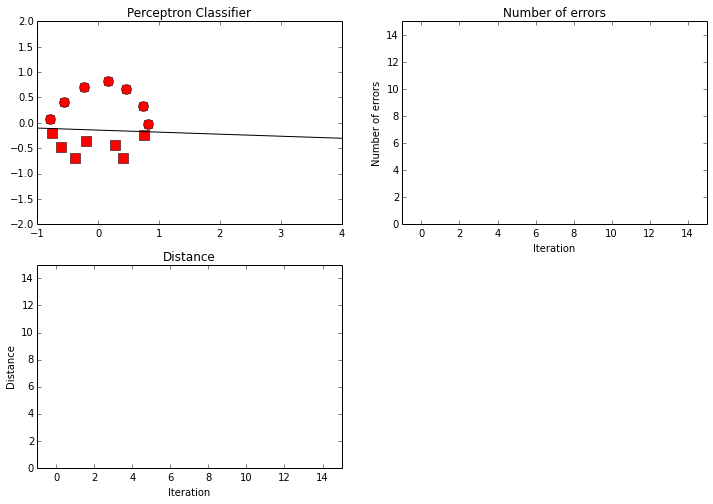

Number of erros in iteration 1:	7
Weights: [[-1.0804893 ]
 [ 0.1084774 ]
 [ 1.28978811]]


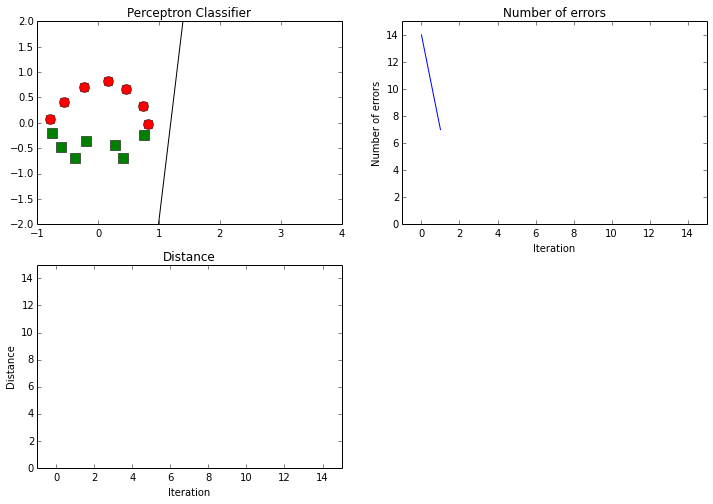

Number of erros in iteration 2:	7
Weights: [[-1.15167901]
 [-0.51173274]
 [ 1.46376591]]


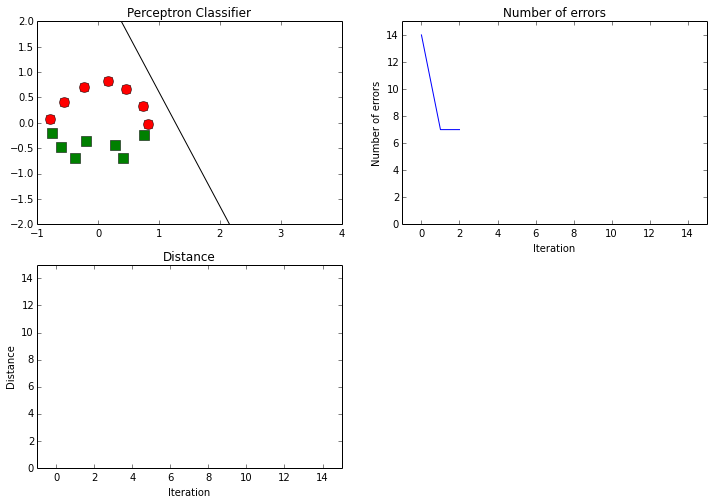

Number of erros in iteration 3:	7
Weights: [[-1.03356641]
 [-1.13470493]
 [ 1.39636868]]


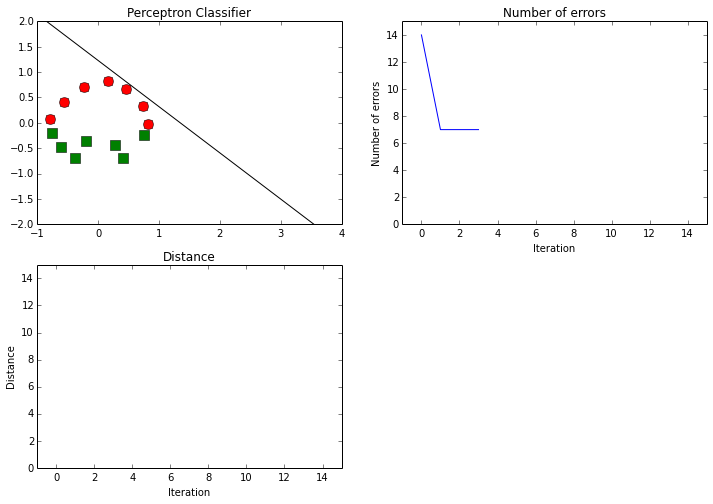

Number of erros in iteration 4:	5
Weights: [[-0.85554089]
 [-1.68366579]
 [ 1.24254825]]


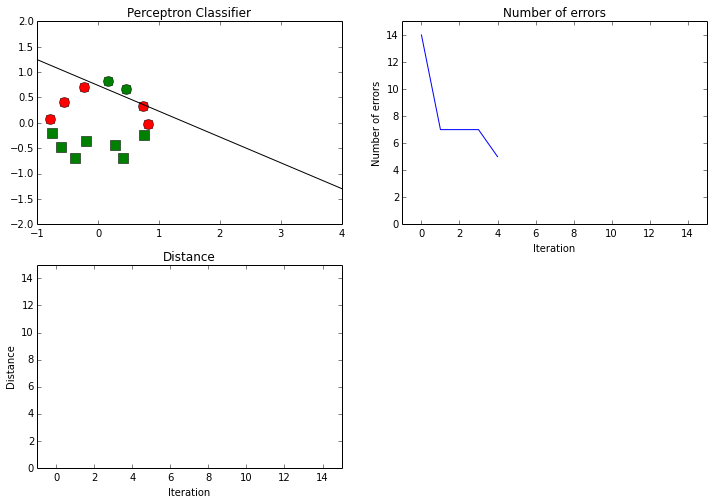

Number of erros in iteration 5:	3
Weights: [[-0.67550655]
 [-2.13746433]
 [ 1.07341717]]


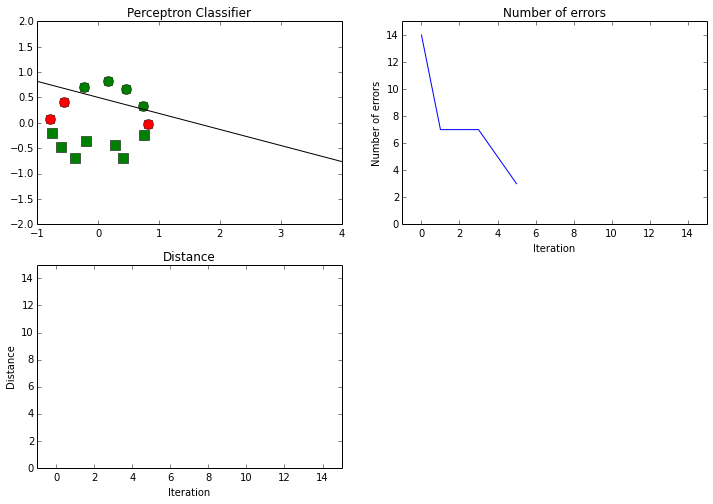

Number of erros in iteration 6:	3
Weights: [[-0.56903571]
 [-2.50206216]
 [ 0.8889202 ]]


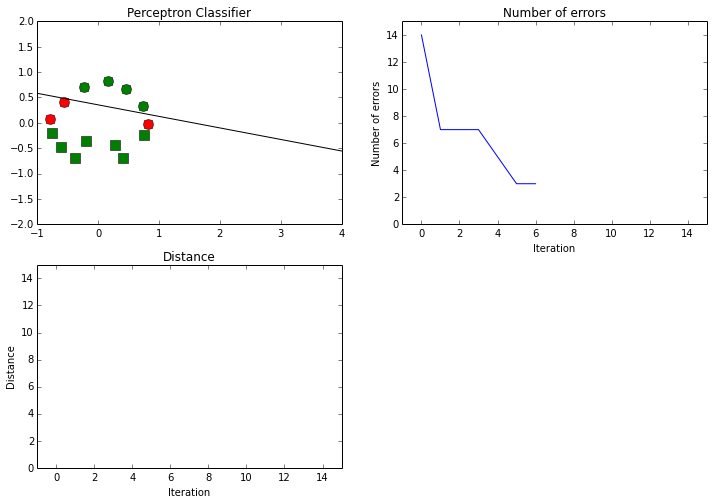

Number of erros in iteration 7:	2
Weights: [[-0.49887712]
 [-2.79007259]
 [ 0.71765488]]


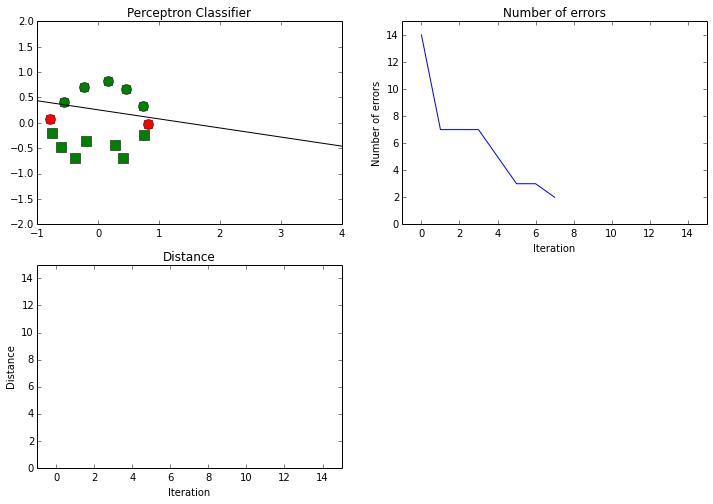

Number of erros in iteration 8:	0
Weights: [[ 0.17631875]
 [-2.86056758]
 [-0.20771062]]


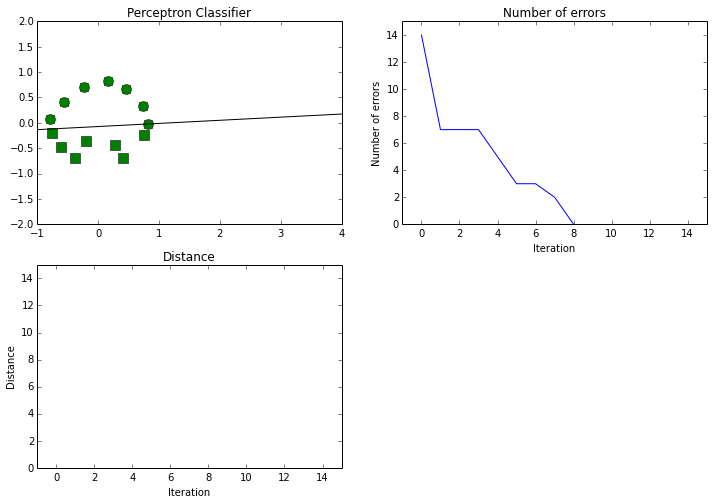

In [12]:
w = learn_perceptron(data['neg_examples_nobias'],
                     data['pos_examples_nobias'],
                     data['w_init'],
                     data['w_gen_feas'],
                     learn_rate=1.0)